# <b> Generative Adversarial Networks </b>

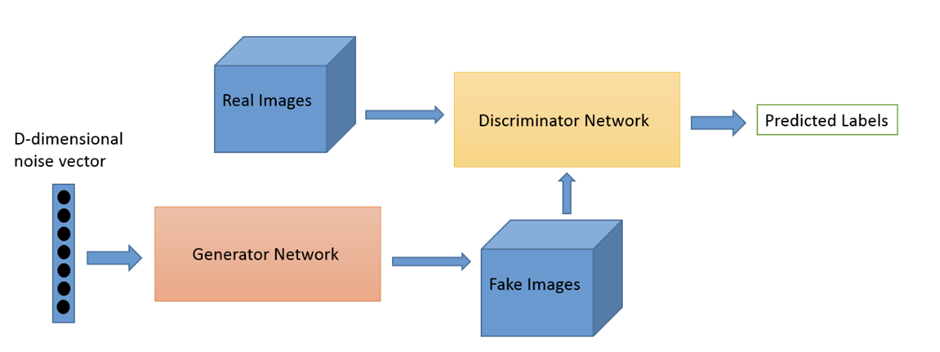

Image Source: https://www.oreilly.com/content/generative-adversarial-networks-for-beginners/

In [1]:
# Importing necessary modules

import random
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

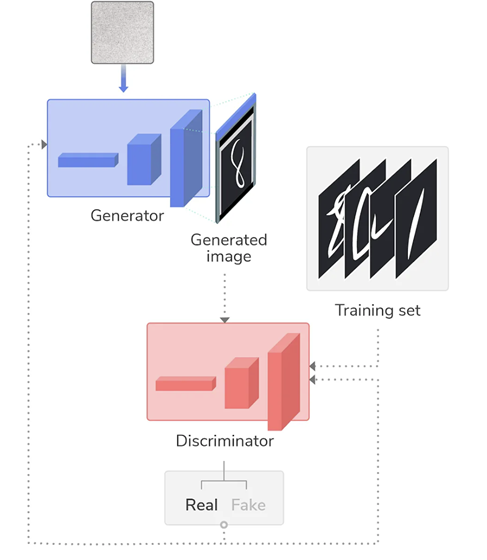

Image Source: https://towardsdatascience.com/exploring-generative-adversarial-networks-gans-488e1d901d4a

#### Dataset loading and Visualisation

Dataset Link: https://www.tensorflow.org/datasets/catalog/mnist

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

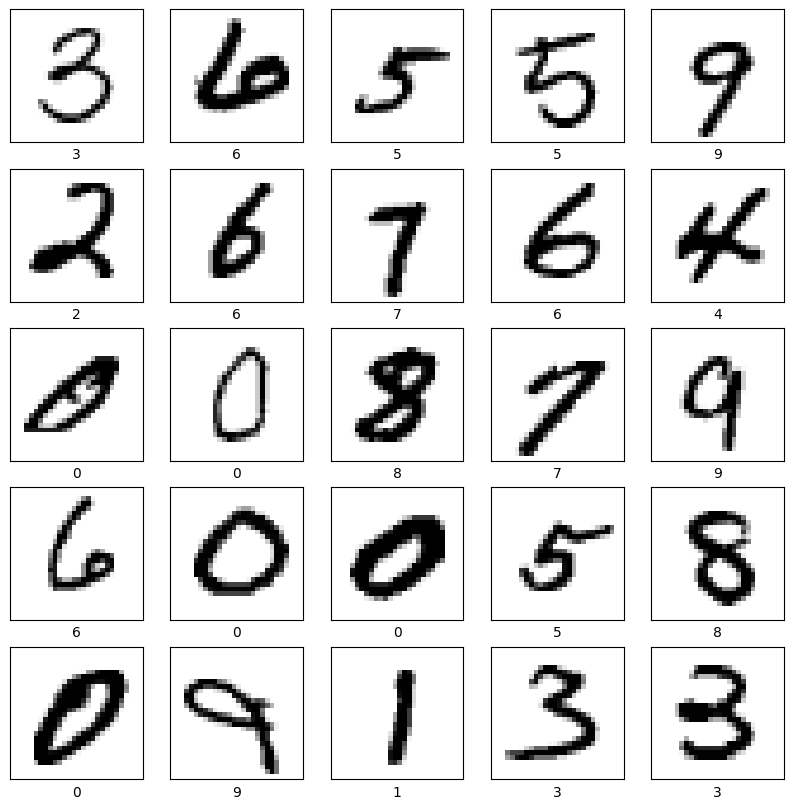

In [3]:
# Visualize the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    index = random.randint(0, len(train_images) - 1)
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.xlabel(train_labels[index])
plt.show()

#### Generative Model Architecture

The generator takes random noise as input and tries to generate data that resembles the true data. It creates fake samples using the input data and tries to make it indistinguishable to the real data. Generator learns to map data from a latent space to the data space.

In [4]:
# Generator network
def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(784, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

#### Discriminative Model Architecture

The discriminator takes the real data and the generated data as input and tries to distinguish the fake data from the real data. The main purpose of the discriminator is to distinguish the fake data from the real data and classify them accordingly

In [5]:
# Discriminator network
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

#### GAN Architecture

In [6]:
# Combining generator and discriminator into GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

#### Function to generate synthetic images

In [7]:
# Function to generate synthetic images
def generate_images(generator, latent_dim, num_images):
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    generated_images = generator.predict(noise)
    return generated_images

#### Training process

In [8]:
# Image Augmentation/Preprocessing
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [9]:
# Hyperparameters
latent_dim = 100
epochs = 30000
batch_size = 128

# Building and compiling the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Building the generator
generator = build_generator(latent_dim)

# Building and compiling the GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

# Training loop
for epoch in range(epochs):
    # Training the discriminator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    generated_images = generator.predict(noise)
    real_images = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
    X = np.concatenate([real_images, generated_images])
    y_dis = np.zeros(2*batch_size)
    y_dis[:batch_size] = 0.9
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X, y_dis)

    # Training the generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gen = np.ones(batch_size)
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

    # Print discriminator and generator loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

4/4 [==============================] - 1s 3ms/step
Epoch 0, Discriminator Loss: 1.1681091785430908, Generator Loss: 0.7002831697463989
4/4 [==============================] - 0s 2ms/step
Epoch 100, Discriminator Loss: 0.33363327383995056, Generator Loss: 2.216535806655884
4/4 [==============================] - 0s 3ms/step
Epoch 200, Discriminator Loss: 0.354986310005188, Generator Loss: 1.7617970705032349
4/4 [==============================] - 0s 1ms/step
Epoch 300, Discriminator Loss: 0.4142819046974182, Generator Loss: 1.7629145383834839
4/4 [==============================] - 0s 2ms/step
Epoch 400, Discriminator Loss: 0.537690281867981, Generator Loss: 1.2255945205688477
4/4 [==============================] - 0s 2ms/step
Epoch 500, Discriminator Loss: 0.5614519119262695, Generator Loss: 1.2823575735092163
4/4 [==============================] - 0s 1ms/step
Epoch 600, Discriminator Loss: 0.6339166164398193, Generator Loss: 1.842193841934204
4/4 [==============================] - 0s 4ms/

In [28]:
# Generate synthetic images
num_images_to_generate = 10
synthetic_images = generate_images(generator, latent_dim, num_images_to_generate)

1/1 [==============================] - 0s 21ms/step


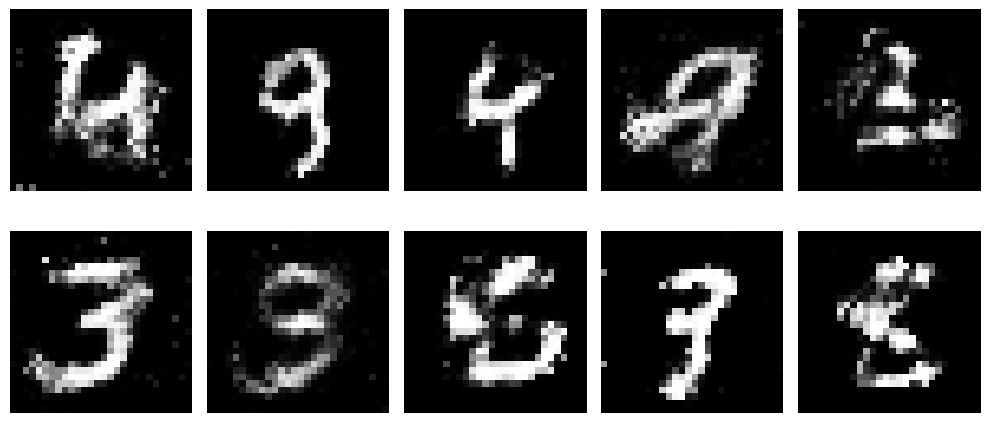

In [29]:
# Visualize generated images
plt.figure(figsize=(10, 5))
for i in range(num_images_to_generate):
    plt.subplot(2, 5, i + 1)
    plt.imshow(synthetic_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

#### Evaluation of GAN performance

Inception Score

In [12]:
# Function to calculate Inception Score
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # Load InceptionV3 model pre-trained on ImageNet
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Convert grayscale images to RGB
    images_rgb = np.repeat(images, 3, axis=-1)

    # Resize images to (299, 299) for InceptionV3 model
    images_resized = []
    for img in images_rgb:
        img_resized = image.array_to_img(img, scale=False)
        img_resized = img_resized.resize((299, 299))
        img_resized = image.img_to_array(img_resized)
        images_resized.append(img_resized)
    images_resized = np.array(images_resized)

    # Preprocessing the images
    images_preprocessed = preprocess_input(images_resized)

    # obtain predictions from InceptionV3 model
    preds = model.predict(images_preprocessed)

    split_scores = []
    for i in range(n_split):
        preds_split = preds[i * (len(preds) // n_split): (i + 1) * (len(preds) // n_split)]
        p_yx = np.exp(preds_split) / np.sum(np.exp(preds_split), axis=1, keepdims=True)
        p_y = np.mean(p_yx, axis=0)
        kl_divergence = np.sum(p_yx * (np.log(p_yx + eps) - np.log(p_y + eps)), axis=1)
        split_scores.append(np.exp(np.mean(kl_divergence)))

    # Calculate Inception Score
    inception_score = np.mean(split_scores)
    return inception_score

# Calculate Inception Score for synthetic images
inception_score = calculate_inception_score(synthetic_images)
print("Inception Score:", inception_score)

1/1 [==============================] - 5s 5s/step
Inception Score: 1.0


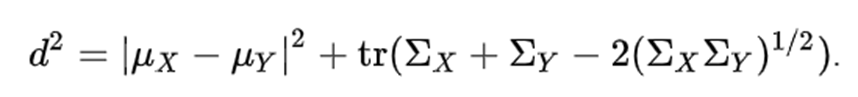

Image Source: https://en.wikipedia.org/wiki/Fr%C3%A9chet_distance#:~:text=The%20Fr%C3%A9chet%20distance%20between%20the,dog%20were%20walking%20its%20owner.

Frechet Inception Distance (FID)

In [13]:
# Function to calculate FID score
def calculate_fid(reference_images, generated_images):
    # Loading InceptionV3 pre-trained on ImageNet model
    inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Image Preprocessing InceptionV3
    def preprocess_images(images):
        # grayscale images to RGB
        if images.shape[-1] == 1:
            images = np.concatenate([images, images, images], axis=-1)
        images_resized = tf.image.resize(images, (299, 299), method='bilinear')
        images_resized = preprocess_input(images_resized)
        return images_resized

    # Preprocess reference and generated images
    real_activations = inception.predict(preprocess_images(reference_images))
    generated_activations = inception.predict(preprocess_images(generated_images))

    # mean and covariance of activations
    mu_real, sigma_real = np.mean(real_activations, axis=0), np.cov(real_activations, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_activations, axis=0), np.cov(generated_activations, rowvar=False)

    # squared Euclidean distance between means
    fid = np.sum((mu_real - mu_generated)**2)

    # trace of covariance product
    cov_product = np.dot(sigma_real, sigma_generated)
    trace_sqrt = np.trace(cov_product)

    # Calculate FID
    fid += np.trace(sigma_real) + np.trace(sigma_generated) - 2 * trace_sqrt

    return fid

num_images = 1000
reference_images = train_images[np.random.choice(train_images.shape[0], num_images, replace=False)]
generated_images = generate_images(generator, latent_dim, num_images)
fid_score = calculate_fid(reference_images, generated_images)
print("FID Score:", fid_score)

32/32 [==============================] - 86s 3s/step
FID Score: 7.342141212017822
